In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torchviz import make_dot, make_dot_from_trace

In [2]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=3 // 2,bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=3 // 2,bias=False)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=3 // 2,bias=False)
        self.conv4 = nn.Conv2d(64, num_channels, kernel_size=3, padding=3 // 2,bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x
model = SRCNN()
print(model)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)


In [3]:
# show output shape and hierarchical view of net
from pytorch_model_summary import summary
print(summary(SRCNN(), torch.zeros((1, 1, 28, 28)), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 28, 28]             576             576
            ReLU-2     [1, 64, 28, 28]               0               0
          Conv2d-3     [1, 64, 28, 28]          36,864          36,864
          Conv2d-4     [1, 64, 28, 28]          36,864          36,864
          Conv2d-5      [1, 1, 28, 28]             576             576
Total params: 74,880
Trainable params: 74,880
Non-trainable params: 0
-----------------------------------------------------------------------


========================================= Hierarchical Summary =========================================

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 576 params
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
  (conv3): Conv2d(64, 64, kernel_size=(3,

In [4]:
# show output shape and hierarchical view of net
from pytorch_model_summary import summary
print(summary(SRCNN(), torch.zeros((1, 1, 28, 28)), show_input=True, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 28, 28]             576             576
            ReLU-2     [1, 64, 28, 28]               0               0
          Conv2d-3     [1, 64, 28, 28]          36,864          36,864
          Conv2d-4     [1, 64, 28, 28]          36,864          36,864
          Conv2d-5     [1, 64, 28, 28]             576             576
Total params: 74,880
Trainable params: 74,880
Non-trainable params: 0
-----------------------------------------------------------------------


========================================= Hierarchical Summary =========================================

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 576 params
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
  (conv3): Conv2d(64, 64, kernel_size=(3,

In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    576     |
| conv2.weight |   36864    |
| conv3.weight |   36864    |
| conv4.weight |    576     |
+--------------+------------+
Total Trainable Params: 74880


74880

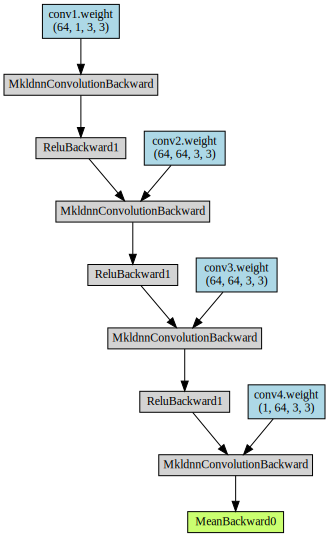

In [6]:
x = Variable(torch.randn(1,1,33,33))
y = model(x)
make_dot(y.mean(),params=dict(model.named_parameters()))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Energy map net
        self.conv1 = nn.Conv2d(19, 32, (1,3), padding=(0,1))
        self.pool = nn.MaxPool2d((1,3))
        self.conv2 = nn.Conv2d(32, 64, (1,3))
        self.fc1 = nn.Linear(64 * 9 * 10, 120)
        self.fc2 = nn.Linear(120, 60)

        # Sequence net
        self.fc3 = nn.Linear(9 * 22, 120)
        self.fc4 = nn.Linear(120, 60)

        # Combine (concatenated 60 + 60)
        self.fc5 = nn.Linear(60 + 60, 120)
        self.fc6 = nn.Linear(120, 2)

    def forward(self, x1, x2):
        # Energy map net
        x1 = self.pool(F.relu(self.conv1(x1)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(-1, 64 * 9 * 10)
        x1 = F.relu(self.fc1(x1))
model = Net()
print(model)

Net(
  (conv1): Conv2d(19, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
  (pool): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
  (fc1): Linear(in_features=5760, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=198, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=60, bias=True)
  (fc5): Linear(in_features=120, out_features=120, bias=True)
  (fc6): Linear(in_features=120, out_features=2, bias=True)
)
